In [1]:
%matplotlib inline

import pandas as pd
import nivapy3 as nivapy
import geopandas as gpd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

In [2]:
# Connect to PostGIS
eng = nivapy.da.connect_postgis()

Connection successful.


# CL Vestland: Process catchment data

## 1. Get catchments of interest

### 1.1. Outflow points

In [3]:
# Get outflows
sql = (
    "SELECT * FROM niva.stations "
    "WHERE station_id IN ( "
    "  SELECT station_id FROM niva.projects_stations "
    "  WHERE project_id IN ( "
    "    SELECT project_id FROM niva.projects "
    "    WHERE project_name = 'CL Vestland' "
    "    ) "
    "  ) "
)
stn_gdf = gpd.read_postgis(sql, eng)

# Reproject to ETRS89 UTM Z33N
stn_gdf = stn_gdf.to_crs({"init": "epsg:25833"})

stn_gdf.head()

/home/jovyan/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,station_id,station_code,station_name,aquamonitor_id,longitude,latitude,geom
0,87,Sam_Froe,Samnanger_Frolandselva,None,5.798510,60.380058,POINT (-6218.205 6729188.752)
1,86,Sam_Stor,Samnanger_Storelva,None,5.798443,60.384011,POINT (-6160.286 6729626.599)
2,84,Sam_Tyss,Samnanger_Tysseelva,None,5.758580,60.374899,POINT (-8485.813 6728926.678)
3,85,Sam_Tyss_IntCat,Samnanger_Tysseelva_Intercatchment,None,5.758580,60.374899,POINT (-8485.813 6728926.678)
4,88,Sam_Frok,Samnanger_Frolandskanalen,None,5.793918,60.381434,POINT (-6448.257 6729376.408)


### 1.2. Catchment boundaries

In [4]:
# Get catchments
stn_list = list(stn_gdf["station_id"].astype(str))
bind_pars = ",".join(stn_list)
sql = f"SELECT * FROM niva.catchments " f"WHERE station_id IN ({bind_pars})"
cat_gdf = gpd.read_postgis(sql, eng)

# Reproject to ETRS89 UTM Z33N
cat_gdf = cat_gdf.to_crs({"init": "epsg:25833"})

# Calculate area
cat_gdf["area_km2"] = cat_gdf["geom"].area / 1e6

cat_gdf.head()

/home/jovyan/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,station_id,geom,area_km2
0,84,"MULTIPOLYGON (((547.072 6746299.978, 595.735 6...",236.241723
1,85,"MULTIPOLYGON (((-6481.562 6728412.895, -6486.3...",6.666451
2,86,"MULTIPOLYGON (((-4989.585 6733365.944, -5033.5...",7.204036
3,87,"MULTIPOLYGON (((2525.877 6733985.895, 2583.556...",96.618777
4,88,"MULTIPOLYGON (((2525.877 6733985.895, 2502.756...",125.752458


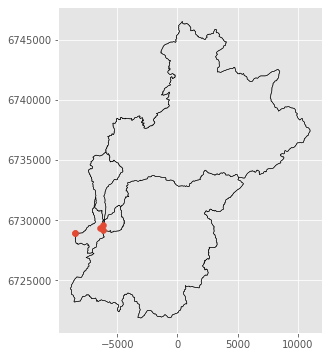

In [5]:
# Plot
ax = cat_gdf.plot(facecolor="none", edgecolor="k", figsize=(6, 6))
stn_gdf.plot(ax=ax)

## 2. Process AR50 and NVE lakes data

### 2.1. Extract ndata from database

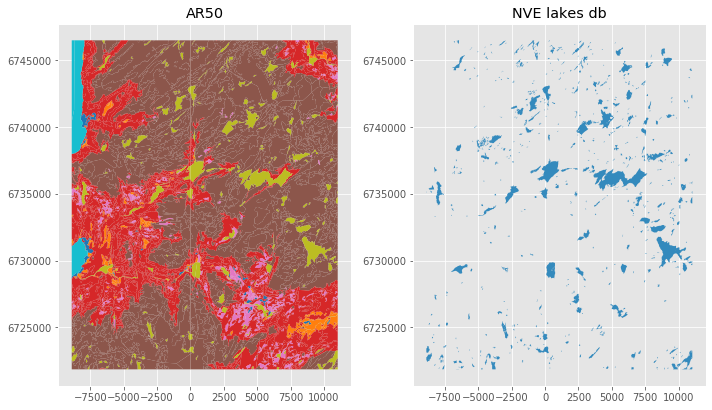

In [6]:
# Read AR50, clipping to catchment bounding box
ar50_gdf = nivapy.da.read_postgis(
    "physical", "norway_nibio_ar50_poly", eng, clip=cat_gdf,
)

# Read NVE lakes database, clipping to catchment bounding box
nve_gdf = nivapy.da.read_postgis(
    "physical", "norway_nve_innsjo_poly", eng, clip=cat_gdf,
)

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axes[0].set_title("AR50")
axes[1].set_title("NVE lakes db")
ar50_gdf.plot("artype", ax=axes[0])
nve_gdf.plot(ax=axes[1])
plt.tight_layout()

### 2.2. Intersect with catchment boundaries

In [7]:
# AR50
ar50_gdf = gpd.overlay(ar50_gdf, cat_gdf, how="intersection")
ar50_gdf = ar50_gdf.dissolve(["station_id", "artype"]).reset_index()
ar50_gdf = ar50_gdf[["station_id", "artype", "description", "geometry"]]
ar50_gdf["area_km2"] = ar50_gdf["geometry"].area / 1e6

# Join station codes
ar50_gdf = ar50_gdf.merge(
    stn_gdf[["station_id", "station_code"]], how="left", on="station_id"
)

# Save
ar50_df = ar50_gdf[["station_id", "station_code", "artype", "description", "area_km2"]]
csv_path = r"../output/cl_vestland_ar50_summary.csv"
ar50_df.to_csv(csv_path, index=False)

# Show forest area
ar50_df.query("artype == '30'")

,station_id,station_code,artype,description,area_km2
2,84,Sam_Tyss,30,Skog: Skogdekt areal,61.545159
8,85,Sam_Tyss_IntCat,30,Skog: Skogdekt areal,5.241346
13,86,Sam_Stor,30,Skog: Skogdekt areal,5.049527
19,87,Sam_Froe,30,Skog: Skogdekt areal,31.463961
25,88,Sam_Frok,30,Skog: Skogdekt areal,19.790326


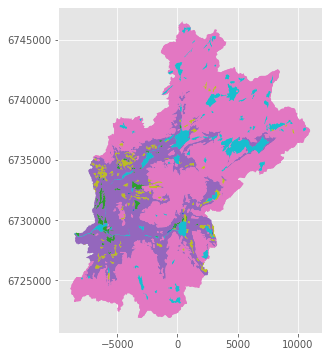

In [8]:
ar50_gdf.plot("artype", figsize=(6, 6))

In [9]:
# Lakes
nve_gdf = gpd.overlay(nve_gdf, cat_gdf, how="intersection")
nve_gdf = nve_gdf.dissolve(["station_id"]).reset_index()
nve_gdf = nve_gdf[["station_id", "geometry"]]
nve_gdf["area_km2"] = nve_gdf["geometry"].area / 1e6

# Join station codes
nve_gdf = nve_gdf.merge(
    stn_gdf[["station_id", "station_code"]], how="left", on="station_id"
)

# Save
nve_df = nve_gdf[["station_id", "station_code", "area_km2"]]
csv_path = r"../output/cl_vestland_nve_lakes_db_summary.csv"
nve_df.to_csv(csv_path, index=False)

nve_df.head()

,station_id,station_code,area_km2
0,84,Sam_Tyss,13.186753
1,85,Sam_Tyss_IntCat,0.391270
2,86,Sam_Stor,0.041816
3,87,Sam_Froe,2.495578
4,88,Sam_Frok,10.258089


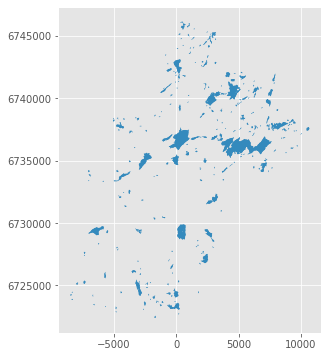

In [10]:
nve_gdf.plot(figsize=(6, 6))